# 0. Install and Import Dependencies

In [1]:
!pip list

Package                      Version   Editable project location
---------------------------- --------- --------------------------------------------
absl-py                      2.0.0
alembic                      1.12.0
anyio                        4.0.0
appnope                      0.1.3
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.2.3
asttokens                    2.4.0
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.1.0
Babel                        2.12.1
backcall                     0.2.0
beautifulsoup4               4.12.2
bleach                       6.0.0
blinker                      1.6.2
boltons                      23.0.0
Brotli                       1.1.0
cachetools                   5.3.1
certifi                      2023.7.22
cffi                         1.15.1
charset-normalizer           3.2.0
click                        8.1.7
cloudpickle                  2.2.1

In [2]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [4]:
tf.config.list_physical_devices('GPU')

[]

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [6]:
import gdown

In [7]:
# url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
# output = 'data.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('data.zip')

In [8]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [9]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [10]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [11]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [12]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [13]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [14]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [15]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    #file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [16]:
test_path = '.data/s1/bbal6n.mpg'

In [17]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbal6n'

In [18]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

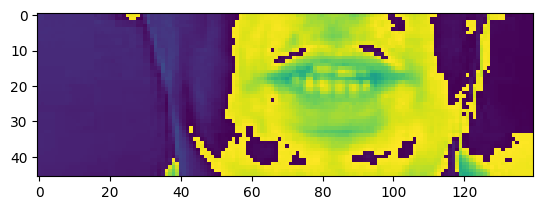

In [19]:
plt.imshow(frames[40])

In [20]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [21]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [22]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [23]:
from matplotlib import pyplot as plt

In [24]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [25]:
frames, alignments = data.as_numpy_iterator().next()

In [26]:
len(frames)

2

In [27]:
sample = data.as_numpy_iterator()

In [28]:
val = sample.next(); val[0]

array([[[[[1.4335093 ],
          [1.4335093 ],
          [1.4335093 ],
          ...,
          [0.11623049],
          [0.07748699],
          [0.07748699]],

         [[1.4335093 ],
          [1.4335093 ],
          [1.4335093 ],
          ...,
          [0.11623049],
          [0.07748699],
          [0.07748699]],

         [[1.4335093 ],
          [1.4335093 ],
          [1.4335093 ],
          ...,
          [0.11623049],
          [0.07748699],
          [0.07748699]],

         ...,

         [[1.0073309 ],
          [1.0073309 ],
          [1.0073309 ],
          ...,
          [9.724618  ],
          [9.724618  ],
          [9.724618  ]],

         [[1.0073309 ],
          [1.0073309 ],
          [1.0073309 ],
          ...,
          [9.724618  ],
          [9.724618  ],
          [9.724618  ]],

         [[1.0073309 ],
          [1.0073309 ],
          [1.0073309 ],
          ...,
          [9.724618  ],
          [9.724618  ],
          [9.724618  ]]],


        [[[1.4335

In [29]:
import imageio
import numpy as np

# Assuming val[0][0] is a sequence of frames

# Reshape the frames if necessary
frames = np.squeeze(val[0][0])

# Normalize the frames to the range [0, 255]
frames_normalized = (frames - np.min(frames)) / (np.max(frames) - np.min(frames))
frames_uint8 = (frames_normalized * 255).astype(np.uint8)

# Save animation as GIF with a frame duration of 100 milliseconds (10 frames per second)
imageio.mimsave('./animation.gif', frames_uint8, duration=100)


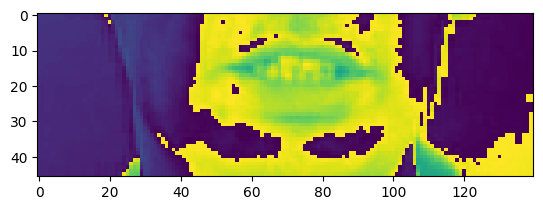

In [30]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][35])

In [31]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set red in a six now'>

# 3. Design the Deep Neural Network

In [32]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [33]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [34]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [36]:
5*17*75

6375

In [37]:
yhat = model.predict(val[0])

1/1 [==============================] - 2s 2s/step


In [38]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'ffffooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo'>

In [39]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'ffffooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo'>

In [40]:
model.input_shape

(None, 75, 46, 140, 1)

In [41]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [42]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [43]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [44]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [45]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss=CTCLoss)

In [46]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [47]:
schedule_callback = LearningRateScheduler(scheduler)

In [48]:
example_callback = ProduceExample(test)

In [49]:
# model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

# 5. Make a Prediction 

In [50]:
# url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
# output = 'checkpoints.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('checkpoints.zip', 'models')

In [51]:
model.load_weights('models/checkpoint')

In [52]:
test_data = test.as_numpy_iterator()

In [53]:
sample = test_data.next()

[mpeg1video @ 0x116e59920] ac-tex damaged at 22 17
[mpeg1video @ 0x116e59920] Warning MVs not available


In [54]:
yhat = model.predict(sample[0])

1/1 [==============================] - 2s 2s/step


In [55]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place green with l two please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place blue by c four now'>]

In [56]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [57]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'place green with l two please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place blue by c four now'>]

# Test on a Video

In [58]:
sample = load_data(tf.convert_to_tensor('./data/s1/bras9a.mpg'))

In [59]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [60]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 819ms/step


In [61]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [62]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

## Evaluation metrics and WER(word error rate)

In [64]:
import pickle

In [65]:
# Path to your pickle file
file_path = 'training_history.pkl'

# Load the pickle file
with open(file_path, 'rb') as file:
    history = pickle.load(file)

In [69]:
loss = history['loss']
val_loss = history['val_loss']

print("Training Loss:", history['loss'])
print("Validation Loss:", history['val_loss'])

Training Loss: [83.79281616210938, 70.4928970336914, 66.44612121582031, 63.673187255859375, 61.62440490722656, 59.958492279052734, 58.774375915527344, 55.535823822021484, 53.508750915527344, 51.969032287597656, 50.19148254394531, 48.309852600097656, 46.725830078125, 44.74922180175781, 42.39545440673828, 40.441646575927734, 38.26045608520508, 36.424137115478516, 33.6458625793457, 31.59272575378418, 29.684171676635742, 27.470741271972656, 25.651981353759766, 23.534584045410156, 21.385910034179688, 19.55805206298828, 17.927127838134766, 16.663753509521484, 15.650525093078613, 14.42288589477539, 13.299582481384277, 12.276954650878906, 11.521810531616211, 10.818806648254395, 10.010773658752441, 9.506612777709961, 8.929075241088867, 8.537317276000977, 8.207317352294922, 7.848769664764404, 7.429142951965332, 7.155651092529297, 6.847716331481934, 6.7192487716674805, 6.46071720123291, 6.332621097564697, 6.21626091003418, 6.086723804473877, 5.866871356964111, 5.816737651824951]
Validation Loss: 

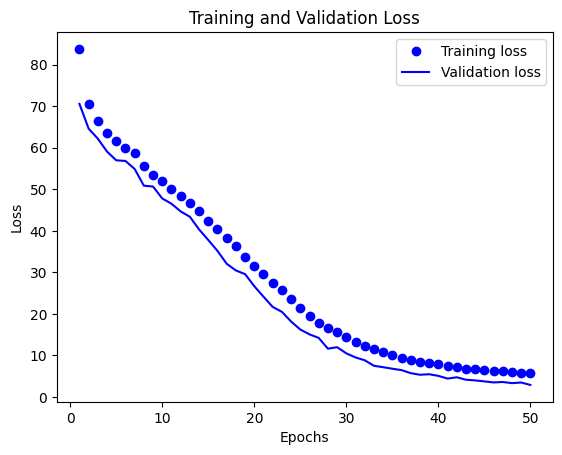

In [71]:
import matplotlib.pyplot as plt

# Assuming you have 'loss' and 'val_loss' from your history file
epochs = range(1, len(history['loss']) + 1)

plt.plot(epochs, history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history['val_loss'], 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

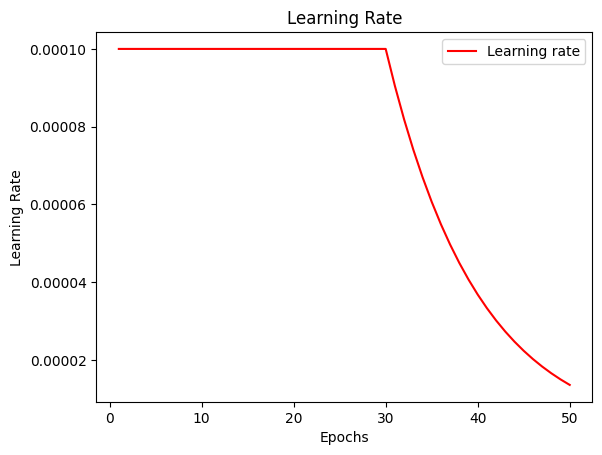

In [72]:
import matplotlib.pyplot as plt

# Assuming you have 'lr' from your history file
epochs = range(1, len(history['lr']) + 1)

plt.plot(epochs, history['lr'], 'r', label='Learning rate')
plt.title('Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()

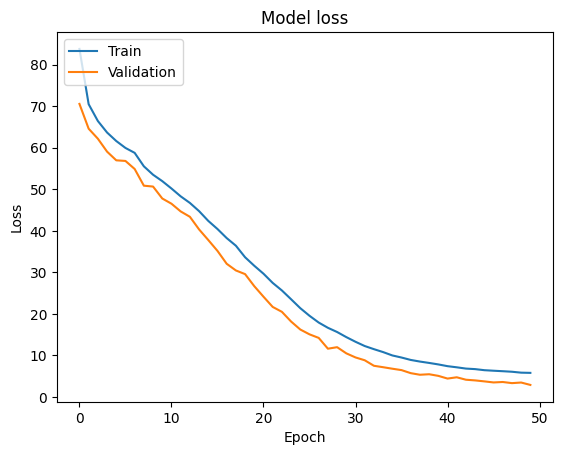

In [76]:
import pickle
import matplotlib.pyplot as plt

# Load the history data from the pickle file
with open('training_history.pkl', 'rb') as file:
    history = pickle.load(file)

# Plotting training & validation loss values
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [77]:
import os
import shutil

# Path to your data and alignments folders
data_folder = 'data/s1'
alignments_folder = 'data/alignments/s1'

# Create a new folder for the validation dataset
validation_data_folder = 'data/validation'

# Get the list of video files
video_files = sorted([filename for filename in os.listdir(data_folder) if filename.endswith('.mpg')])

# Take the last 50 videos for validation
validation_videos = video_files[-50:]

# Create folders for validation data and alignments if they don't exist
os.makedirs(os.path.join(validation_data_folder, 'videos'), exist_ok=True)
os.makedirs(os.path.join(validation_data_folder, 'alignments'), exist_ok=True)

# Copy the validation videos and alignments to the new validation folders
for video_file in validation_videos:
    video_path = os.path.join(data_folder, video_file)
    alignment_path = os.path.join(alignments_folder, video_file.replace('.mpg', '.align'))
    
    shutil.copy(video_path, os.path.join(validation_data_folder, 'videos', video_file))
    shutil.copy(alignment_path, os.path.join(validation_data_folder, 'alignments', video_file.replace('.mpg', '.align')))

In [84]:
def predict_videos(model, video_folder):
    predictions = []
    video_filenames = os.listdir(video_folder)
    video_filenames.sort()

    for video_filename in video_filenames:
        video_path = os.path.join(video_folder, video_filename)
        # Load video frames and preprocess if needed
        # Predict using the loaded model
        video_predictions = model.predict(video_path)
        # Post-process predictions if necessary
        predictions.append(video_predictions)
    
    return predictions

In [85]:
def load_ground_truths(alignments_path, video_filenames):
    ground_truths = []
    
    for video_filename in video_filenames:
        if not video_filename.endswith('.mpg'):
            continue
        alignment_filename = video_filename.replace('.mpg', '.align')
        alignment_path = os.path.join(alignments_path, alignment_filename)
        
        with open(alignment_path, 'r') as file:
            ground_truth = file.read().strip()  # Assuming alignments are in text format
        ground_truths.append(ground_truth)
    
    return ground_truths

In [86]:
from jiwer import wer

def calculate_wer(ground_truths, predictions):
    wer_scores = []
    
    for idx, (ground_truth, prediction) in enumerate(zip(ground_truths, predictions)):
        wer_score = wer(ground_truth, prediction)
        wer_scores.append(wer_score)
        print(f"Video {idx + 1} - WER: {wer_score:.4f}")
    
    mean_wer = sum(wer_scores) / len(wer_scores)
    print(f"Mean WER: {mean_wer:.4f}")

In [95]:
# Load your trained model
model.load_weights('models/checkpoint')  # Load your model with its weights

videos_folder = 'data/validation/videos'  # Directory containing validation videos

video_filenames = os.listdir(videos_folder)
video_filenames.sort()

predictions_list = []

for video_filename in video_filenames:
    video_path = os.path.join(videos_folder, video_filename)
    video_data = load_data(tf.convert_to_tensor(video_path))
    yhat = model.predict(tf.expand_dims(video_data[0], axis=0))
    decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()
    predictions = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]
    predictions_list.append(predictions)

1/1 [==============================] - 1s 810ms/step


In [96]:
for predictions in predictions_list:
    print(predictions)

[<tf.Tensor: shape=(), dtype=string, numpy=b'set white at v one again'>]
[<tf.Tensor: shape=(), dtype=string, numpy=b'set white at v zero please'>]
[<tf.Tensor: shape=(), dtype=string, numpy=b'set white by c one soon'>]
[<tf.Tensor: shape=(), dtype=string, numpy=b'set white by c two please'>]
[<tf.Tensor: shape=(), dtype=string, numpy=b'set white by c three again'>]
[<tf.Tensor: shape=(), dtype=string, numpy=b'set white by c zero now'>]
[<tf.Tensor: shape=(), dtype=string, numpy=b'set white by i four now'>]
[<tf.Tensor: shape=(), dtype=string, numpy=b'set white by i five soon'>]
[<tf.Tensor: shape=(), dtype=string, numpy=b'set white by i six please'>]
[<tf.Tensor: shape=(), dtype=string, numpy=b'set white by i seven again'>]
[<tf.Tensor: shape=(), dtype=string, numpy=b'set white by o eight now'>]
[<tf.Tensor: shape=(), dtype=string, numpy=b'set white by o nine soon'>]
[<tf.Tensor: shape=(), dtype=string, numpy=b'set white by p one again'>]
[<tf.Tensor: shape=(), dtype=string, numpy=b's

In [97]:
for predictions in predictions_list:
    for prediction in predictions:
        if isinstance(prediction, tf.Tensor):
            print(prediction.numpy().decode('utf-8'))

set white at v one again
set white at v zero please
set white by c one soon
set white by c two please
set white by c three again
set white by c zero now
set white by i four now
set white by i five soon
set white by i six please
set white by i seven again
set white by o eight now
set white by o nine soon
set white by p one again
set white by p zero please
set white by v two now
set white by v three soon
set white by v four please
set white by v five again
set white in b two now
set white in b three soon
set white in b four please
set white in b five again
set white in h six now
set white in seven soon
set white in h eight please
set white in t nine again
set white in o one soon
set white in o two please
set white in o three again
set white in o zero now
set white in u four now
set white in u five soon
set white in u six please
set white in u seven again
set white with c four now
set white with c five soon
set white with c six please
set white with c seveven again
set white with i eight 

In [98]:
predictions_text = []

for predictions in predictions_list:
    for prediction in predictions:
        if isinstance(prediction, tf.Tensor):
            predictions_text.append(prediction.numpy().decode('utf-8'))

In [110]:
import os

ground_truths = []

alignments_folder = 'data/validation/alignments'
alignment_filenames = os.listdir(alignments_folder)
alignment_filenames.sort()

for alignment_filename in alignment_filenames:
    alignment_path = os.path.join(alignments_folder, alignment_filename)
    with open(alignment_path, 'r') as file:
        lines = file.readlines()
        text_segments = [line.split(maxsplit=2)[-1].strip() for line in lines if not line.startswith('0') and not line.strip().endswith('sil')]
        ground_truth = ' '.join(text_segments)
        ground_truths.append(ground_truth)

In [111]:
print(ground_truths)

['set white at v one again', 'set white at v zero please', 'set white by c one soon', 'set white by c two please', 'set white by c three again', 'set white by c zero now', 'set white by i four now', 'set white by i five soon', 'set white by i six please', 'set white by i seven again', 'set white by o eight now', 'set white by o nine soon', 'set white by p one again', 'set white by p zero please', 'set white by v two now', 'set white by v three soon', 'set white by v four please', 'set white by v five again', 'set white in b two now', 'set white in b three soon', 'set white in b four please', 'set white in b five again', 'set white in h six now', 'set white in h seven soon', 'set white in h eight please', 'set white in h nine again', 'set white in o one soon', 'set white in o two please', 'set white in o three again', 'set white in o zero now', 'set white in u four now', 'set white in u five soon', 'set white in u six please', 'set white in u seven again', 'set white with c four now', '

In [112]:
print(predictions_text)

['set white at v one again', 'set white at v zero please', 'set white by c one soon', 'set white by c two please', 'set white by c three again', 'set white by c zero now', 'set white by i four now', 'set white by i five soon', 'set white by i six please', 'set white by i seven again', 'set white by o eight now', 'set white by o nine soon', 'set white by p one again', 'set white by p zero please', 'set white by v two now', 'set white by v three soon', 'set white by v four please', 'set white by v five again', 'set white in b two now', 'set white in b three soon', 'set white in b four please', 'set white in b five again', 'set white in h six now', 'set white in seven soon', 'set white in h eight please', 'set white in t nine again', 'set white in o one soon', 'set white in o two please', 'set white in o three again', 'set white in o zero now', 'set white in u four now', 'set white in u five soon', 'set white in u six please', 'set white in u seven again', 'set white with c four now', 'se

In [114]:
import jiwer

# Calculate WER
wer = jiwer.wer(ground_truths, predictions_text)
print(f"Word Error Rate: {wer}")

error_percentage = wer * 100
print(f"Error Percentage: {error_percentage:.2f}%")

Word Error Rate: 0.016611295681063124
Error Percentage: 1.66%
